## ITE 17 Data Mining

Final Activity 2 [By Pair]: Time Series Forecasting

Due Date: July 7, 2025

Objectives:
1. Develop a time series forecast model for time series data. Develop a time series forecasting model for the productsales.csv dataset. Use the total sales data covered from years 2010-2018 for training and the dates covered by the year
2019 for testing.

2. Explore the data and apply preprocessing techniques (including testing stationarity) prior
to developing the model. Apply descriptive analysis and interpret the results (ex: Which
product type is the most or least sold? Which stores have the most or least number of
action figures sold?)

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Data exploration
sales = pd.read_csv("../data/productsales.csv")
print(sales.head())  # First few rows
print(sales.info())  # Column types & missing values
print(sales.isnull().sum())  # Missing values per column
sales['date'].describe()  # Check time range/frequency
sales.duplicated().sum() # Check for duplicated entries

# Preprocess data
sales['date'] = pd.to_datetime(sales['date']) # Convert date column to datetime data type
sales = sales.sort_values('date')  # Ensure chronological order

# Aggregate total daily sales (across all stalls and products)
daily_sales = sales.groupby('date')['number_sold'].sum().reset_index()
daily_sales.set_index('date', inplace=True)


   stall_id  product_type        date  number_sold
0         0             0  2010-01-01          801
1         0             0  2010-01-02          810
2         0             0  2010-01-03          818
3         0             0  2010-01-04          796
4         0             0  2010-01-05          808
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   stall_id      255640 non-null  int64 
 1   product_type  255640 non-null  int64 
 2   date          255640 non-null  object
 3   number_sold   255640 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ MB
None
stall_id        0
product_type    0
date            0
number_sold     0
dtype: int64


#### Used Exploratory Data Analysis (EDA) to analyze the dataset
- still exploring the dataset

Top 3 Products by Sales:
 product_type
7    21293947
4    20955555
6    20573320
Name: number_sold, dtype: int64
Bottom 3 Products by Sales:
 product_type
3    18964340
0    18620577
8    18361679
Name: number_sold, dtype: int64

Top 3 Stalls by Sales:
 stall_id
4    35614244
5    32561336
6    31896887
Name: number_sold, dtype: int64
Bottom 3 Stalls by Sales:
 stall_id
2    29943377
1    26309774
3    12566763
Name: number_sold, dtype: int64


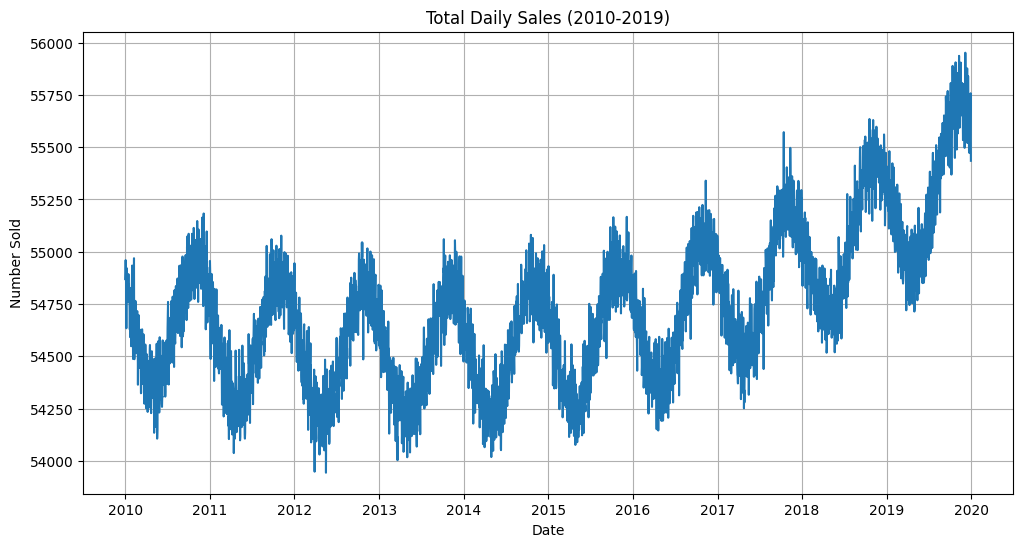

In [37]:
# 1. Most/Least Sold Products
product_stats = sales.groupby('product_type')['number_sold'].sum().sort_values(ascending=False)
print("Top 3 Products by Sales:\n", product_stats.head(3))
print("Bottom 3 Products by Sales:\n", product_stats.tail(3))

# 2. Most/Least Profitable Stalls
stall_stats = sales.groupby('stall_id')['number_sold'].sum().sort_values(ascending=False)
print("\nTop 3 Stalls by Sales:\n", stall_stats.head(3))
print("Bottom 3 Stalls by Sales:\n", stall_stats.tail(3))

plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['number_sold'])
plt.title("Total Daily Sales (2010-2019)")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.grid()
plt.show()

#### Stationarity Check
- used Augmented Dickey-Fuller (ADF) test to determine if a series is stationary.
- still exploring dataset

3. Explore and provide the metrics used to evaluate the performance of the developed
model. Provide the results and remarks.

In [38]:
adf_test = adfuller(daily_sales['number_sold'])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Series is non-stationary. Applying differencing...")
    daily_sales['sales_diff'] = daily_sales['number_sold'].diff().dropna()
    adf_diff = adfuller(daily_sales['sales_diff'].dropna())
    print(f"ADF after differencing: p-value = {adf_diff[1]}")

ADF Statistic: -2.5000751663648724, p-value: 0.11545603704178542
Series is non-stationary. Applying differencing...
ADF after differencing: p-value = 7.989694483221977e-10


#### Decompose to check trend/seasonality
- to check underlying patterns and dynamics of the data
- still exploring dataset

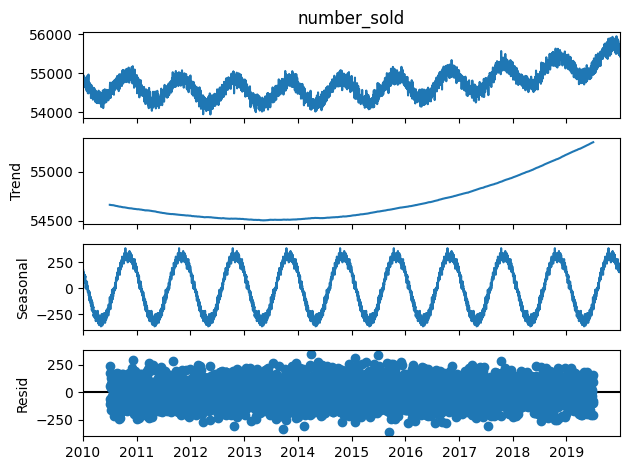

In [39]:
decomposition = seasonal_decompose(daily_sales['number_sold'], period=365)  # Annual seasonality
decomposition.plot()
plt.show()

4. Present plots of the actual and predicted data.

###### 4.1 Developing the SARIMA model for time series

c:\Users\Admin\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                       number_sold   No. Observations:                 3287
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -19431.190
Date:                           Sun, 06 Jul 2025   AIC                          38868.379
Time:                                   16:24:20   BIC                          38886.665
Sample:                               01-01-2010   HQIC                         38874.927
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8030      0.011    -75.533      0.000      -0.824      -0.782
ma.S.L7       -0.9994      0.021    -48.162

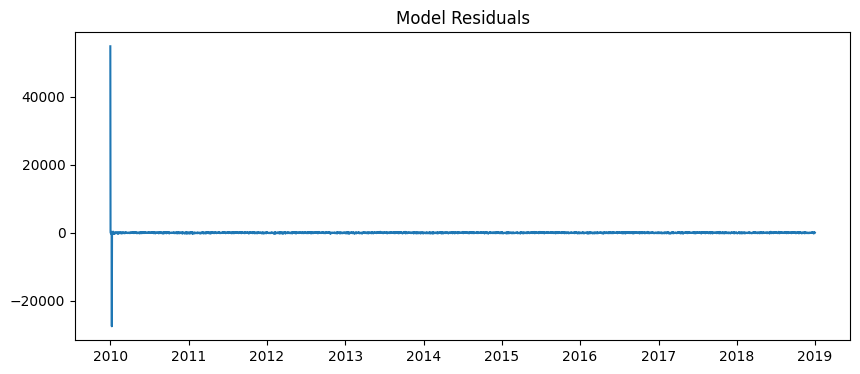

In [40]:
# --- Train-Test Split ---
train = daily_sales.loc['2010-01-01':'2018-12-31']
test = daily_sales.loc['2019-01-01':'2019-12-31']

# --- Model Training (SARIMA) ---
# Example parameters (adjust based on ACF/PACF plots in practice)
model = SARIMAX(train['number_sold'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit(disp=False)
print(results.summary())

residuals = results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Model Residuals")
plt.show()

Forecasting on Test Set

In [41]:
forecast = results.get_forecast(steps=len(test))
predicted_sales = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

Evaluation Metrics
- used MAE, RMSE, and MAPE to evaluate the predictions

In [42]:
mae = mean_absolute_error(test['number_sold'], predicted_sales)
rmse = np.sqrt(mean_squared_error(test['number_sold'], predicted_sales))
mape = np.mean(np.abs((test['number_sold'] - predicted_sales) / test['number_sold'])) * 100

print("\n=== Model Performance ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


=== Model Performance ===
MAE: 258.72
RMSE: 297.41
MAPE: 0.47%


Visualization of the Actual vs the Predicted

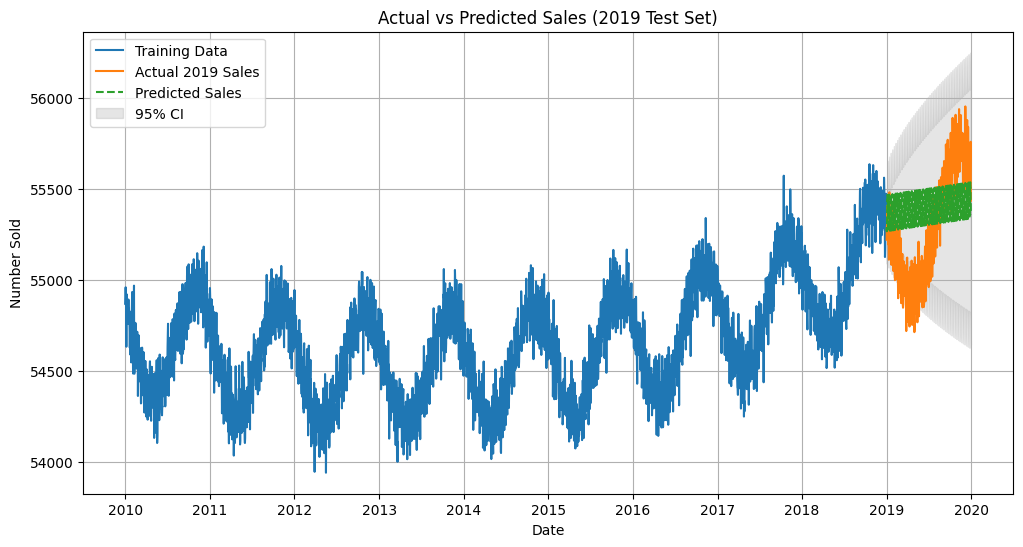

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['number_sold'], label='Training Data')
plt.plot(test.index, test['number_sold'], label='Actual 2019 Sales')
plt.plot(test.index, predicted_sales, label='Predicted Sales', linestyle='--')
plt.fill_between(test.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='gray', alpha=0.2, label='95% CI')
plt.title("Actual vs Predicted Sales (2019 Test Set)")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.grid()
plt.show()